In [1]:
import os
import numpy as np
from nanowire.optics.simulate import Simulator
from nanowire.optics.postprocess import Simulation
from nanowire.optics.utils.utils import setup_sim
from nanowire.optics.utils.config import Config
from nanowire.optics.utils.geometry import get_layers
import scipy.constants as consts
import scipy.integrate as intg
import IPython.display as disp
import matplotlib.pyplot as plt
import time
from itertools import product
%load_ext autoreload 
%autoreload 2

In [2]:
def integrate(arr, xvals, yvals):
    x_integral = intg.trapz(arr, x=xvals, axis=0)
    y_integral = intg.trapz(x_integral, x=yvals, axis=0)
    return y_integral

In [4]:
conf = Config('InPlaneSampleTest.yml')
sim = Simulator(conf)
sim.setup()

In [5]:
ITO_locs = np.linspace(.5, .8, 4, endpoint=False)
NW_locs = np.linspace(.8, .8+1.3, 4, endpoint=False)
Sub_locs = np.linspace(.8+1.3, .8+1.3+1, 4, endpoint=False)
z_vals = np.concatenate((ITO_locs, NW_locs, Sub_locs))
#z_vals = NW_locs

In [6]:
num_points = np.arange(50, 550, 50)
pairs = list(zip(num_points, num_points))
#pairs = list(product(num_points, num_points))
#pairs.sort(key=lambda tup: tup[0]*tup[1])
print(list(pairs))

[(50, 50), (100, 100), (150, 150), (200, 200), (250, 250), (300, 300), (350, 350), (400, 400), (450, 450), (500, 500)]


In [7]:
results = np.zeros((len(pairs), z_vals.shape[0]))
freq = sim.conf[('Simulation', 'params', 'frequency')]
for i, (xpts, ypts) in enumerate(pairs):
    #print('#'*25)
    #print('Computing with {} points per edge'.format(pts))
    times = np.zeros(z_vals.shape[0])
    sim.xsamps = xpts
    sim.ysamps = ypts
    layers = get_layers(sim)
    for j, z in enumerate(z_vals):
        #print('Computing at z = {:.2f}'.format(z))
        layer_obj = [layer for layer in layers.values() if layer.start <= z <= layer.end].pop()
        n_mat, k_mat = layer_obj.get_nk_matrix(freq)
        xvals = np.linspace(0, sim.period, xpts)
        yvals = np.linspace(0, sim.period, ypts)
        Ex, Ey, Ez, Hx, Hy, Hz = sim.compute_fields_on_plane(z, xpts, ypts)
        #print('Time to compute: {:.2f} seconds'.format(diff))
        normEsq = np.absolute(Ex)**2 + np.absolute(Ey)**2 + np.absolute(Ez)**2
        #print(normE.shape)
        #res = integrate(normEsq, xvals, yvals)
        res = integrate(n_mat*k_mat*normEsq, xvals, yvals)
        #print('Result: {:.6f}'.format(res))
        results[i, j] = res
        #if j == 1:
        #    plt.figure()
        #    plt.imshow(normE)
        #    plt.show()
        #    input('Continue?')
    #print('Avg Time: {}'.format(avg_time))
print('Done!')

Done!


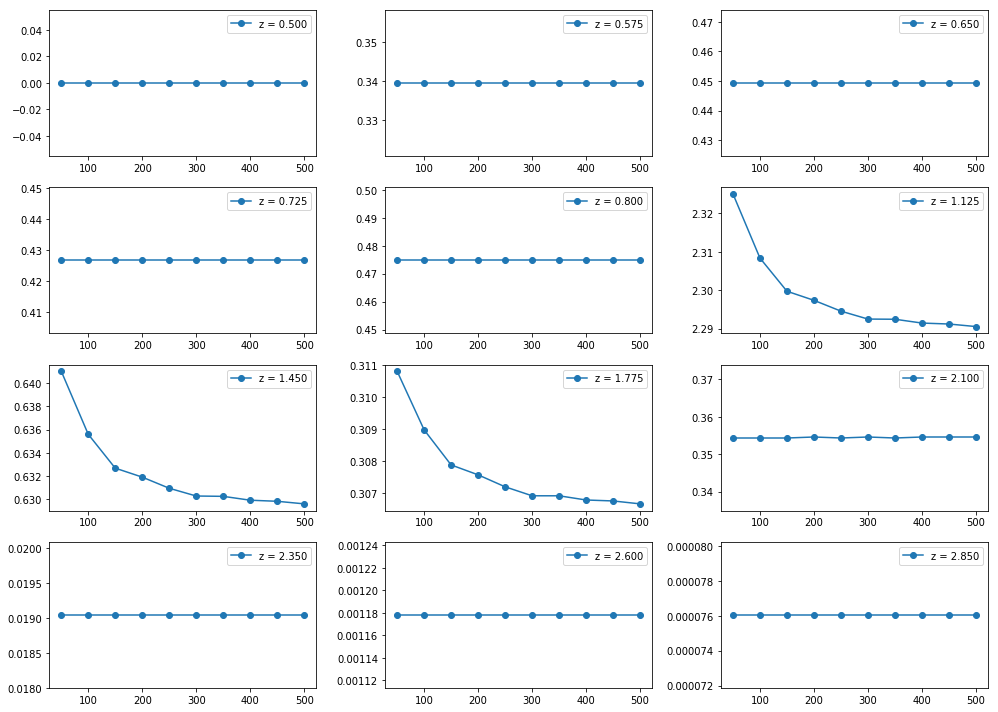

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(14, 10))
axes = axes.flatten()
total_pts = np.array([tup[0] for tup in pairs])
for i, z in enumerate(z_vals):
    axes[i].plot(total_pts, results[:, i], marker='o', label="z = {:.3f}".format(z))
    axes[i].legend(loc='best')
plt.tight_layout()
plt.show()